In [180]:
import random
import math
import matplotlib.pyplot as plt
from deap import base,  benchmarks, creator, tools
import array
import numpy as np
import copy



In [181]:


def generateES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator


def ES_algo( toolbox,mu, lamda_, cxpb=0.6, mutpb=0.3, max_iter=100):
    
    # Init mu number of parents 
    pop = toolbox.population(n=mu)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"


    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in range(1, max_iter +1):
        
        offsprings = []

        while len(offsprings) < lamda_:
            # Probability of selecting parents
            # Creats offspring
            if random.random() < cxpb:
                p1, p2 = random.sample(pop,2)
                children = toolbox.mate(p1,p2)
            else:
                parent = random.choice(pop)
                children = [parent]

            for child in children:
                if random.random() < mutpb:
                    toolbox.mutate(child)

                child.fitness.values = toolbox.evaluate(child)

            offsprings.extend(children)


            # Select best  mu indivudals
        pop = tools.selBest(offsprings, mu)

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(f"Gen {gen}: {record}")
        

    return pop, hof, logbook


# Will do adaptive eso
def ES(dimension, fitness, mu, lambda_, l_bound, h_bound, min_mut, max_mut, max_iter=100, seed=None):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
    creator.create("Strategy", array.array, typecode="d")

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    dimension, l_bound, h_bound, min_mut, max_mut)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxESBlend, alpha=0.1)

    # This samples from a normal distribution
    toolbox.register("mutate", tools.mutESLogNormal, c=0.1, indpb=0.05)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    toolbox.decorate("mate", checkStrategy(min_mut))
    toolbox.decorate("mutate", checkStrategy(min_mut))

    (pop, hof, logbook) = ES_algo(toolbox, mu, lambda_, max_iter=max_iter)


    return logbook, hof


In [182]:
class Individual_EP:
    def __init__(self, l_bound, h_bound, min_mut, max_mut, dimension, rng):
        self.l_bound = l_bound
        self.h_bound = h_bound
        self.rng = rng  # save the generator

        # Initialize x and mutation levels using the rng
        self.x = [self.rng.uniform(l_bound, h_bound) for _ in range(dimension)]
        self.mut_lev = [self.rng.uniform(min_mut, max_mut) for _ in range(dimension)]

        self.fitness = float('inf')
        self.tau = 1 / math.sqrt(2 * math.sqrt(dimension))
        self.tau_prime = 1 / math.sqrt(2 * dimension)

    def update_mut_level(self):
        a = self.rng.normal(0, 1)
        for i in range(len(self.mut_lev)):
            b = self.rng.normal(0, 1)
            old_mut = self.mut_lev[i]
            self.mut_lev[i] = old_mut * math.exp(self.tau_prime * a + self.tau * b)

    def update_x(self, dist):
        self.update_mut_level()
        for i in range(len(self.x)):
            old_x = self.x[i]
            mutated_x = old_x + self.mut_lev[i] * dist[i]
            self.x[i] = max(self.l_bound, min(self.h_bound, mutated_x))

    def clone(self):
        return copy.deepcopy(self)

In [183]:
def ind_mutation(ind, dimension, rng):
    ind_1 = ind.clone()
    ind_2 = ind.clone()

    # Use the generator rng
    normal_dist = rng.normal(size=dimension)
    cauchy_samples = rng.standard_cauchy(size=dimension)

    ind_1.update_x(normal_dist)
    ind_2.update_x(cauchy_samples)

    return ind_1, ind_2

def select_best_ind(ind_1, ind_2, fitness):
    ind_1.fitness = fitness(ind_1.x)
    ind_2.fitness = fitness(ind_2.x)
    return ind_1 if ind_1.fitness <= ind_2.fitness else ind_2

def EP(dimension, pop_size, fitness, l_bound, h_bound, min_mut, max_mut, max_iter=100, seed=100):
    rng = np.random.default_rng(seed)  # create a reproducible generator

    # Create initial population
    pop = [Individual_EP(l_bound, h_bound, min_mut, max_mut, dimension, rng=rng) for _ in range(pop_size)]
    
    # Calculate initial fitness
    for p in pop:
        p.fitness = fitness(p.x)

    best_per_gen = []

    for _ in range(max_iter):
        offspring = []

        for ind in pop:
            ind_1, ind_2 = ind_mutation(ind, dimension, rng)
            best_child = select_best_ind(ind_1, ind_2, fitness)
            offspring.append(best_child)

        combined = pop + offspring
        combined.sort(key=lambda ind: ind.fitness)  # minimize
        pop = combined[:pop_size]

        best_per_gen.append(pop[0].clone())  # log best

    return pop, best_per_gen


In [184]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return (total,)

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return (sum_term - prod_term + 1,)

In [185]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def table_and_avg_plot(seed_res):
    final_bests = []
    all_best_values = []

    # --- Collect per-seed results ---
    for res in seed_res:
        seed = res['seed']
        fitness_values = res['best_values']   # already a list of floats

        final_bests.append(fitness_values[-1])    # last fitness of the run
        all_best_values.append(fitness_values)    # full trajectory

    # --- Average over seeds ---
    max_len = max(len(v) for v in all_best_values)
    arr = np.full((len(all_best_values), max_len), np.nan)
    for i, v in enumerate(all_best_values):
        arr[i, :len(v)] = v
    
    mean_over_gens = np.nanmean(arr, axis=0)
    std_over_gens = np.nanstd(arr, axis=0)

    # --- Plot only average curve ---
    plt.figure(figsize=(8,5))
    gens = np.arange(1, len(mean_over_gens)+1)
    plt.plot(gens, mean_over_gens, label="Mean Best Fitness")
    plt.fill_between(gens,
                     mean_over_gens - std_over_gens,
                     mean_over_gens + std_over_gens,
                     alpha=0.3, label="±1 Std Dev")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Average Best Fitness Across Seeds")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Create summary table ---
    df = pd.DataFrame({
        'Seed': [res['seed'] for res in seed_res],
        'Best Fitness': final_bests
    })

    # Append mean and std
    summary_row = pd.DataFrame({
        'Seed': ['Mean', 'Std'],
        'Best Fitness': [np.mean(final_bests), np.std(final_bests)]
    })

    final_table = pd.concat([df, summary_row], ignore_index=True)
    return final_table


In [187]:
def run_seed_EP(dimension,fitness, seeds=[500,1000,1500,2000,2500]):

    seed_res = []

    for seed in seeds:
        
        (pop, best_gen) = EP(dimension, 100, fitness,-30, 30, 0.1, 1, seed=seed, max_iter=30)

        seed_res.append({
            "seed":seed,
            "best_values": [ind.fitness[0] for ind in best_gen]
        })

    return seed_res


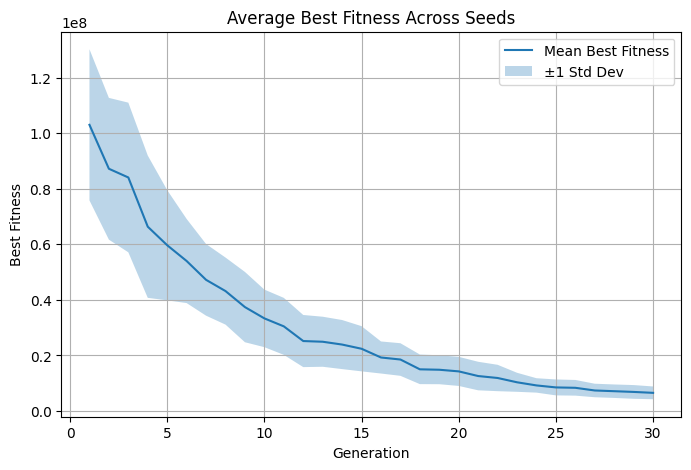

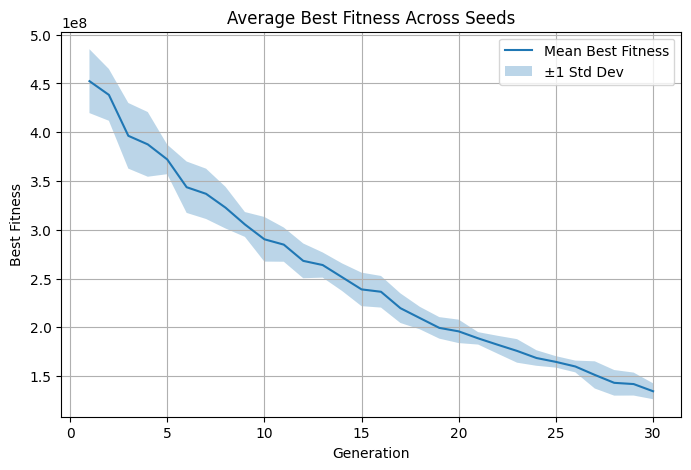

,Seed,Best Fitness
0,500,1.482874e+08
1,1000,1.288727e+08
2,1500,1.384966e+08
3,2000,1.310373e+08
4,2500,1.253433e+08
5,Mean,1.344075e+08
6,Std,8.167299e+06


In [188]:
seed_res = run_seed_EP(20, rosenbrock_fitness)
table_and_avg_plot(seed_res)

seed_res = run_seed_EP(50, rosenbrock_fitness)
table_and_avg_plot(seed_res)

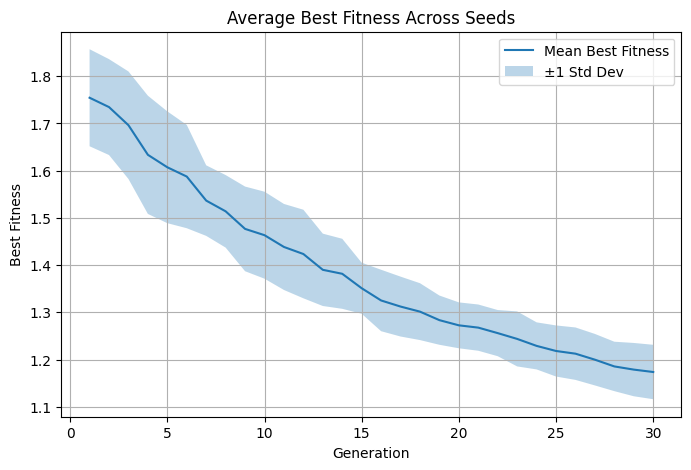

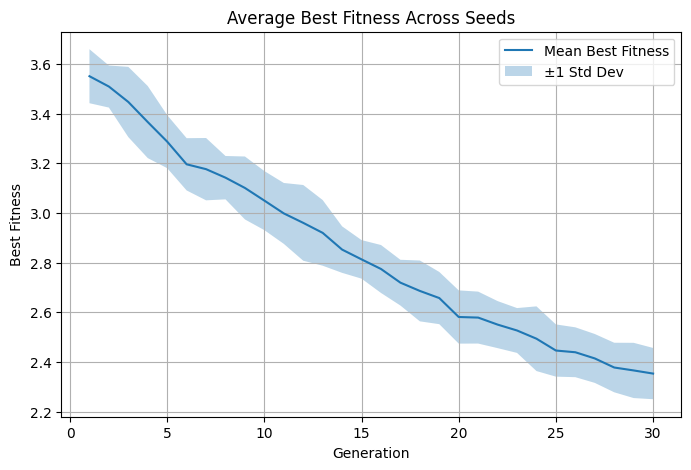

,Seed,Best Fitness
0,500,2.347991
1,1000,2.455649
2,1500,2.343799
3,2000,2.170347
4,2500,2.449428
5,Mean,2.353443
6,Std,0.103253


In [189]:
seed_res = run_seed_EP(20, griewank_fitness)
table_and_avg_plot(seed_res)

seed_res = run_seed_EP(50, griewank_fitness)
table_and_avg_plot(seed_res)

In [194]:
def run_seed_ES(dimension,fitness, seeds=[500,1000,1500,2000,2500]):

    seed_res = []

    for seed in seeds:
        
        (logbook,hfa) = ES(dimension,fitness, 30, 50, -30, 30, 0.1, 1, max_iter=30, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": logbook.select("min")
        })

    return seed_res

Gen 1: {'avg': np.float64(1.7662896071046594), 'std': np.float64(0.10048714410167202), 'min': np.float64(1.5783777003022577), 'max': np.float64(1.8835519156135103)}
Gen 2: {'avg': np.float64(1.241131961980359), 'std': np.float64(0.05548792287189943), 'min': np.float64(1.1977782905228607), 'max': np.float64(1.357604612351641)}
Gen 3: {'avg': np.float64(1.102557216783127), 'std': np.float64(0.0019592044512013245), 'min': np.float64(1.1007245488313675), 'max': np.float64(1.1046516944422806)}
Gen 4: {'avg': np.float64(1.1031407545521825), 'std': np.float64(0.0002645728559369768), 'min': np.float64(1.1030369805402447), 'max': np.float64(1.1038152856297772)}
Gen 5: {'avg': np.float64(1.1059213976613538), 'std': np.float64(0.0007617199612571173), 'min': np.float64(1.104218140048164), 'max': np.float64(1.1062620491839914)}
Gen 6: {'avg': np.float64(1.1029177171485611), 'std': np.float64(2.220446049250313e-16), 'min': np.float64(1.1029177171485613), 'max': np.float64(1.1029177171485613)}
Gen 7:

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

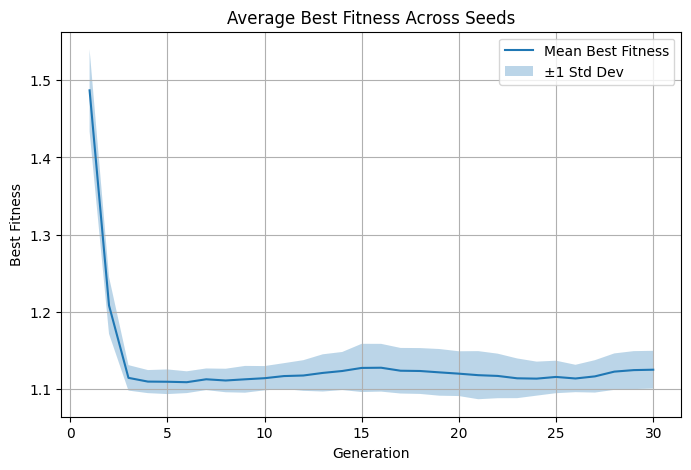

Gen 1: {'avg': np.float64(2.823714174868875), 'std': np.float64(0.3654058415558482), 'min': np.float64(2.0837570384156754), 'max': np.float64(3.165791160354819)}
Gen 2: {'avg': np.float64(1.7919344186684592), 'std': np.float64(0.07358641396189176), 'min': np.float64(1.7061869925107436), 'max': np.float64(1.8850519556323797)}
Gen 3: {'avg': np.float64(1.4007399833304797), 'std': np.float64(0.03008879753474288), 'min': np.float64(1.3681756746421536), 'max': np.float64(1.4410700693233622)}
Gen 4: {'avg': np.float64(1.3929220066360912), 'std': np.float64(0.00041867098007926113), 'min': np.float64(1.3927347712817582), 'max': np.float64(1.3938581834077546)}
Gen 5: {'avg': np.float64(1.4013026487823), 'std': np.float64(0.0032285320951841614), 'min': np.float64(1.3930714747054973), 'max': np.float64(1.4025689832556538)}
Gen 6: {'avg': np.float64(1.3961342279153897), 'std': np.float64(0.0), 'min': np.float64(1.3961342279153897), 'max': np.float64(1.3961342279153897)}
Gen 7: {'avg': np.float64(1

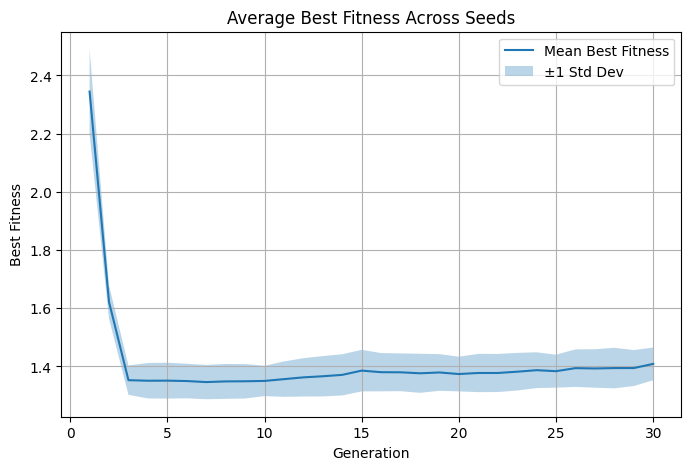

,Seed,Best Fitness
0,500,1.483323
1,1000,1.371716
2,1500,1.368837
3,2000,1.470779
4,2500,1.350247
5,Mean,1.408980
6,Std,0.056206


In [196]:
seed_res = run_seed_ES(20, griewank_fitness)
table_and_avg_plot(seed_res)

seed_res = run_seed_ES(50, griewank_fitness)
table_and_avg_plot(seed_res)

Gen 1: {'avg': np.float64(93687597.0773749), 'std': np.float64(23471478.61150563), 'min': np.float64(52649766.566707425), 'max': np.float64(153814043.76356804)}
Gen 2: {'avg': np.float64(15264110.602095556), 'std': np.float64(9771571.113909211), 'min': np.float64(6167064.178741042), 'max': np.float64(32003985.595584065)}
Gen 3: {'avg': np.float64(1466884.2574030196), 'std': np.float64(473017.68497239874), 'min': np.float64(812279.7997246861), 'max': np.float64(1913511.0370928494)}
Gen 4: {'avg': np.float64(1232559.4578579783), 'std': np.float64(50148.05230015456), 'min': np.float64(1191613.7446147173), 'max': np.float64(1293978.0277228698)}
Gen 5: {'avg': np.float64(1208523.1438512837), 'std': np.float64(2.3283064365386963e-10), 'min': np.float64(1208523.143851284), 'max': np.float64(1208523.143851284)}
Gen 6: {'avg': np.float64(1181407.0252993698), 'std': np.float64(2.3283064365386963e-10), 'min': np.float64(1181407.0252993696), 'max': np.float64(1181407.0252993696)}
Gen 7: {'avg': np

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it

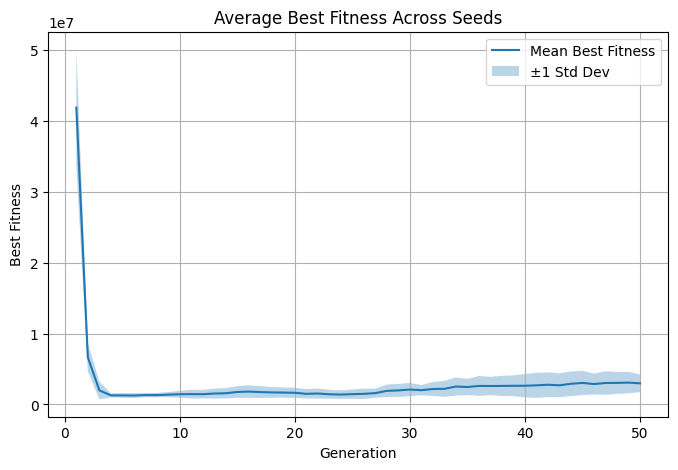

Gen 1: {'avg': np.float64(268303067.03431982), 'std': np.float64(74990656.71160036), 'min': np.float64(110966029.44151542), 'max': np.float64(375206307.90326273)}
Gen 2: {'avg': np.float64(65624391.913555495), 'std': np.float64(24507872.954459365), 'min': np.float64(31050604.59498282), 'max': np.float64(86027601.78692323)}
Gen 3: {'avg': np.float64(14299034.949747114), 'std': np.float64(829170.2357985646), 'min': np.float64(12972592.039331004), 'max': np.float64(15348948.917177988)}
Gen 4: {'avg': np.float64(13302410.983398529), 'std': np.float64(261989.33286703003), 'min': np.float64(13091862.328523902), 'max': np.float64(13781876.351411698)}
Gen 5: {'avg': np.float64(13323917.983123409), 'std': np.float64(3.725290298461914e-09), 'min': np.float64(13323917.983123405), 'max': np.float64(13323917.983123405)}
Gen 6: {'avg': np.float64(14657341.01451223), 'std': np.float64(3.725290298461914e-09), 'min': np.float64(14657341.014512226), 'max': np.float64(14657341.014512226)}
Gen 7: {'avg': 

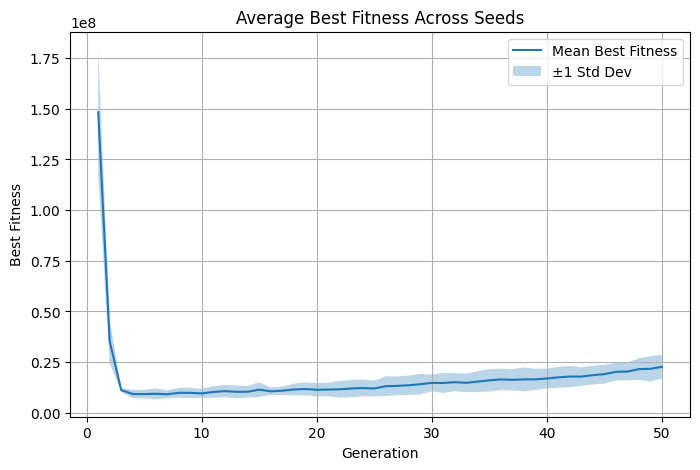

,Seed,Best Fitness
0,500,2.589033e+07
1,1000,1.791423e+07
2,1500,1.867116e+07
3,2000,1.782514e+07
4,2500,3.285416e+07
5,Mean,2.263100e+07
6,Std,5.935668e+06


In [193]:
seed_res = run_seed_ES(20, rosenbrock_fitness)
table_and_avg_plot(seed_res)

seed_res = run_seed_ES(50, rosenbrock_fitness)
table_and_avg_plot(seed_res)